In [ ]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pygmmis
from sklearn.cluster import KMeans
import json

In [2]:
vphi_data = 'df_v_final.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [3]:
pd.set_option('display.max_columns', None)

df_v.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,R_gal,phi_gal,Z_gal,v_phi,v_R,v_Z,rpgeo_error,v_R_uncertainty,v_phi_uncertainty,v_Z_uncertainty
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.582006,-0.522061,470.485258,0.055731,-520.632142,243.095762,-14.428048,4.529900,9.436554,0.205318,0.064645,0.226755
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.375831,-1.403210,1268.325930,0.060773,-1399.358389,237.364263,42.346437,-2.860027,68.673585,1.199227,0.372403,1.029146
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.420638,-0.339539,308.483632,0.064184,-338.602406,230.329127,-51.045366,13.944756,3.087768,0.194034,0.100426,0.199619
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.351665,-1.404413,1245.041147,0.073347,-1400.635394,217.472712,62.829005,-53.068842,74.445250,3.110205,1.267245,3.430299
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.903067,-0.879697,793.842786,0.072479,-877.288236,231.337541,1.866465,13.969564,23.551575,0.309798,0.298155,0.315210


In [4]:
df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_R_uncertainty", "v_phi_uncertainty", "v_Z", "v_Z_uncertainty"])

In [5]:
import pandas as pd
from tqdm import tqdm

def filter_metallicity_bin(df, min_mh, max_mh):
    """
    Filter the dataframe to get stars in the specified metallicity range.
    Args:
    - df: The dataframe containing the data.
    - min_mh: The minimum metallicity value.
    - max_mh: The maximum metallicity value.
    
    Returns:
    - df_bin: The filtered dataframe containing only the stars in the metallicity range.
    """
    df_bin = df[(df['mh_xgboost'] >= min_mh) & (df['mh_xgboost'] < max_mh)]
    return df_bin


In [6]:
df_vmp = filter_metallicity_bin(df_v,-3,-2)
df_imp = filter_metallicity_bin(df_v,-2,-1.6)
df_mp1 = filter_metallicity_bin(df_v,-1.6,-1.3)
df_mp2 = filter_metallicity_bin(df_v,-1.3,-1)

In [7]:
df_vmp.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,R_gal,phi_gal,Z_gal,v_phi,v_R,v_Z,rpgeo_error,v_R_uncertainty,v_phi_uncertainty,v_Z_uncertainty
423,5154922827885952,170.657245,-47.285226,43.071608,4.076372,0.379446,0.018582,19.793915,0.019437,-13.200543,0.015717,1.001329,241.080760,0.804695,11.705599,12.154115,11.079555,9.670,9.672,-2.247,5021.5,1.920,False,43.071608,4.076372,5154922827885952,43.071608,4.076372,2631.75171,2511.39502,2774.26025,2703.14990,2576.89185,2839.44165,10033,0.0,0.048971,0.061986,2703.14990,9.935816,-1.986112,1847.736334,0.161813,-1980.563197,-28.672386,228.320454,-141.733613,131.27490,3.273386,14.402553,1.480388
1426,15542185269834624,168.864959,-39.383137,47.301290,10.900462,0.427245,0.018026,-8.020415,0.020875,-18.292858,0.018016,1.167779,-81.168310,1.635135,11.517186,12.196043,10.710206,8.748,8.761,-2.221,4903.6,1.568,False,47.301290,10.900462,15542185269834624,47.301290,10.900462,2337.60181,2257.49438,2416.28564,2274.19897,2195.37769,2377.09839,10033,0.0,0.042192,0.296176,2274.19897,9.852534,-1.442986,1770.129000,0.192972,-1437.698310,152.431999,-183.267474,-100.993822,90.86035,4.492863,2.996476,6.190263
1975,23128987300185088,161.113675,-46.079151,38.591744,9.022822,0.444738,0.014322,21.460042,0.017848,-24.744448,0.012503,0.926389,7.878022,2.235724,13.051845,13.524738,12.401903,10.960,10.970,-2.186,5152.8,2.699,True,38.591744,9.022822,23128987300185088,38.591744,9.022822,2229.59668,2154.65747,2303.80908,2266.88599,2199.64355,2361.91919,10033,0.0,0.032204,0.162144,2266.88599,9.623270,-1.632835,1584.923568,0.326941,-1628.267978,-98.174807,36.122335,-62.336769,81.13782,1.641303,12.150945,2.709389
1978,23153245275421056,160.116715,-46.808666,37.604696,8.792205,0.457407,0.014301,19.199156,0.017124,-19.458318,0.015217,1.025100,34.055855,0.302539,10.773192,11.395339,10.010570,8.241,8.254,-2.034,4689.2,1.403,False,37.604696,8.792205,23153245275421056,37.604696,8.792205,2177.61157,2120.57544,2255.33105,2185.53516,2127.50269,2252.32031,10033,0.0,0.031266,0.131318,2185.53516,9.542260,-1.593413,1508.139330,0.344088,-1589.093041,-25.620412,62.095080,-58.999607,62.40881,1.072166,7.872995,1.232714
2604,29649366130846592,166.103287,-38.041565,46.481259,13.308729,0.582180,0.015261,55.151524,0.018218,-44.976356,0.014909,1.024042,-19.305912,0.781499,11.957616,12.479722,11.261567,9.667,9.662,-2.222,5013.3,2.375,False,46.481259,13.308729,29649366130846592,46.481259,13.308729,1713.93958,1675.46558,1756.53162,1726.30408,1681.89514,1778.89758,10033,0.0,0.026214,0.228905,1726.30408,9.447425,-1.063806,1370.678841,0.240542,-1059.753273,-328.322431,99.860631,15.821360,48.50122,3.482296,17.934260,0.497230


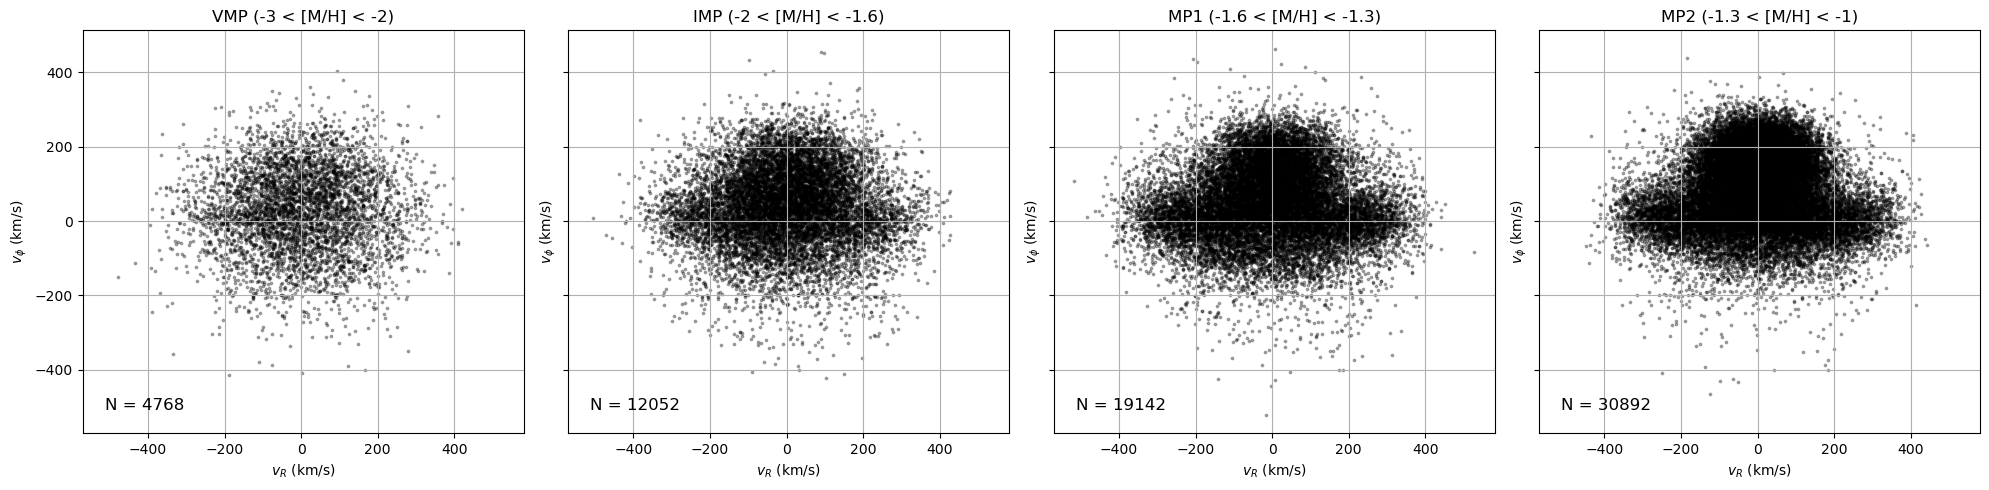

In [8]:
import matplotlib.pyplot as plt

def plot_vphi_vs_vR(df_vmp, df_imp, df_mp1, df_mp2):
    """
    Plots v_phi against v_R for each metallicity bin in four subfigures (1 row, 4 columns).
    Adds the number of data points in the bottom left of each graph.

    Args:
    - df_vmp: DataFrame for -3 < [M/H] < -2
    - df_imp: DataFrame for -2 < [M/H] < -1.6
    - df_mp1: DataFrame for -1.6 < [M/H] < -1.3
    - df_mp2: DataFrame for -1.3 < [M/H] < -1
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
    
    metallicity_bins = [
        ("VMP (-3 < [M/H] < -2)", df_vmp),
        ("IMP (-2 < [M/H] < -1.6)", df_imp),
        ("MP1 (-1.6 < [M/H] < -1.3)", df_mp1),
        ("MP2 (-1.3 < [M/H] < -1)", df_mp2)
    ]
    
    for ax, (title, df) in zip(axes, metallicity_bins):
        ax.scatter(df['v_R'], df['v_phi'], alpha=0.3, s=3, color='black')
        ax.set_title(title)
        ax.set_xlabel(r'$v_R$ (km/s)')
        ax.set_ylabel(r'$v_\phi$ (km/s)')
        ax.grid(True)
        
        # Add number of data points
        num_points = len(df)
        ax.text(0.05, 0.05, f'N = {num_points}', transform=ax.transAxes,
                fontsize=12, verticalalignment='bottom', horizontalalignment='left')

    plt.tight_layout()
    plt.show()

# Call the function
plot_vphi_vs_vR(df_vmp, df_imp, df_mp1, df_mp2)


# BIC function

In [15]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from tqdm import tqdm

def compute_bic_vs_n_components(df_bin, max_components=8, n_init=50):
    """
    Compute BIC for different numbers of Gaussian components (1 to max_components),
    using Extreme Deconvolution (XD) to account for measurement uncertainties.

    Args:
    - df_bin: DataFrame containing the data for a metallicity bin.
    - max_components: Maximum number of components to test.
    - n_init: Number of different random initializations per component count.

    Returns:
    - BIC_values: Dictionary storing min, median, and max BIC for each component count.
    """
    X = df_bin[['v_R', 'v_phi', 'v_Z']].values  # Extract velocity space
    n = len(X)  # Number of stars

    # Construct per-star diagonal covariance matrices from measurement uncertainties
    uncertainties = np.stack([
        df_bin['v_R_uncertainty'].values**2,
        df_bin['v_phi_uncertainty'].values**2,
        df_bin['v_Z_uncertainty'].values**2
    ], axis=1)
    cov_matrices = np.array([np.diag(uncertainty) for uncertainty in uncertainties])

    BIC_values = {N: [] for N in range(1, max_components + 1)}

    print("\nComputing BIC for different numbers of components...")
    rng = np.random.RandomState()

    for N in tqdm(range(1, max_components + 1), desc="Fitting GMMs"):
        for _ in range(n_init):  # Run multiple initializations per N
            gmm = pygmmis.GMM(K=N, D=3)  # GMM in 3D velocity space

            # Initialize using KMeans
            pygmmis.initFromKMeans(gmm, X)

            # Fit GMM using Extreme Deconvolution (XD) and required parameters
            logL, _ = pygmmis.fit(gmm, X, covar=cov_matrices, w=0.1, tol=1e-6, init_method='kmeans')

            # Compute BIC using BIC = k*ln(n) - 2*logL
            k = (1 + 3 + 6) * N - 1  # Number of parameters for N components
            BIC = k * np.log(n) - 2 * logL
            BIC_values[N].append(BIC)

    return BIC_values


In [22]:
def plot_bic_vs_n_components(BIC_values):
    """
    Plots BIC vs. Number of Components.

    Args:
    - BIC_values: Dictionary with BIC values for each component count.
    """
    num_components = sorted(BIC_values.keys())  # Sorted list of component numbers
    
    smallest_bic = [min(BIC_values[N]) for N in num_components]
    median_bic = [np.median(BIC_values[N]) for N in num_components]
    largest_bic = [max(BIC_values[N]) for N in num_components]
    q25_bic = [np.percentile(BIC_values[N], 25) for N in num_components]  # 25th percentile
    q75_bic = [np.percentile(BIC_values[N], 75) for N in num_components]  # 75th percentile

    plt.figure(figsize=(8, 6))
    plt.plot(num_components, smallest_bic, 'k-', label='Smallest BIC')
    plt.plot(num_components, q25_bic, 'g-.', label='25th Percentile BIC')
    plt.plot(num_components, median_bic, 'b--', label='Median BIC')
    plt.plot(num_components, q75_bic, '-.', label='75th Percentile BIC')
    plt.plot(num_components, largest_bic, 'r:', label='Largest BIC')

    plt.xlabel("Number of GMM Components")
    plt.ylabel("BIC Value")
    plt.title("BIC vs Number of Components")
    plt.legend()
    plt.grid(True)
    plt.show()

# VPM

In [ ]:
bic_values_vmp = compute_bic_vs_n_components(df_vmp, max_components=8, n_init=50)


Computing BIC for different numbers of components...


Fitting GMMs:  75%|███████▌  | 6/8 [45:30<18:11, 545.81s/it]

/Users/raunaqrai/opt/anaconda3/envs/mphil/lib/python3.9/site-packages/pygmmis.py:539: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  center, label = kmeans2(data, gmm.K)



Fitting GMMs: 100%|██████████| 8/8 [1:19:00<00:00, 592.62s/it]


In [31]:
with open("bic_values_vmp.json", "w") as f:
    json.dump(bic_values_vmp, f)


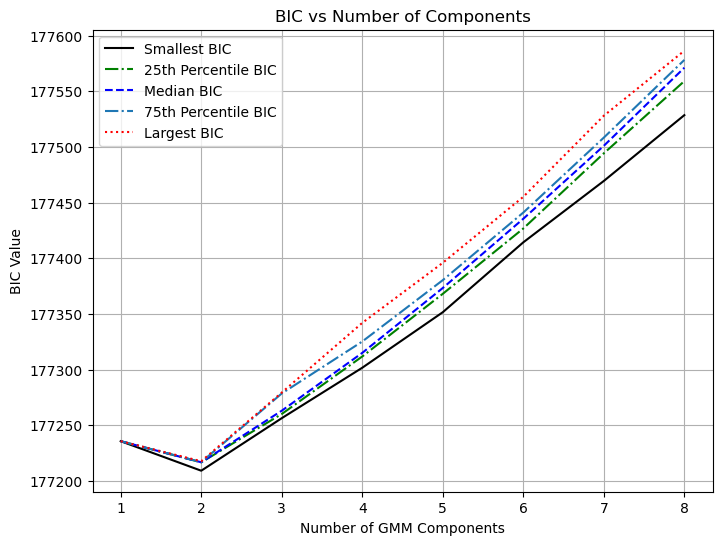

In [32]:
plot_bic_vs_n_components(bic_values_vmp)

# IMP

In [ ]:
bic_values_imp = compute_bic_vs_n_components(df_imp, max_components=8, n_init=50)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [3:19:46<00:00, 1498.32s/it]  


In [ ]:
with open("bic_values_imp.json", "w") as f:
    json.dump(bic_values_imp, f)


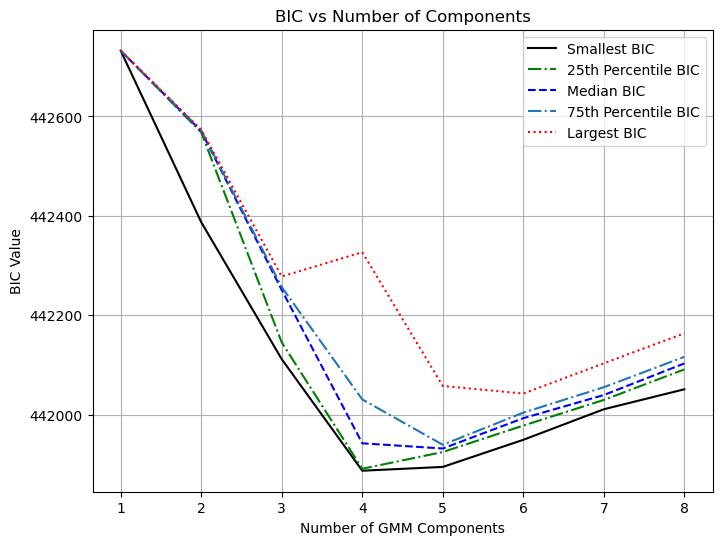

In [33]:
plot_bic_vs_n_components(bic_values_imp)

# MP1

In [34]:
bic_values_mp1 = compute_bic_vs_n_components(df_mp1, max_components=8, n_init=50)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [3:48:15<00:00, 1711.95s/it]  


In [35]:
with open("bic_values_mp1.json", "w") as f:
    json.dump(bic_values_mp1, f)


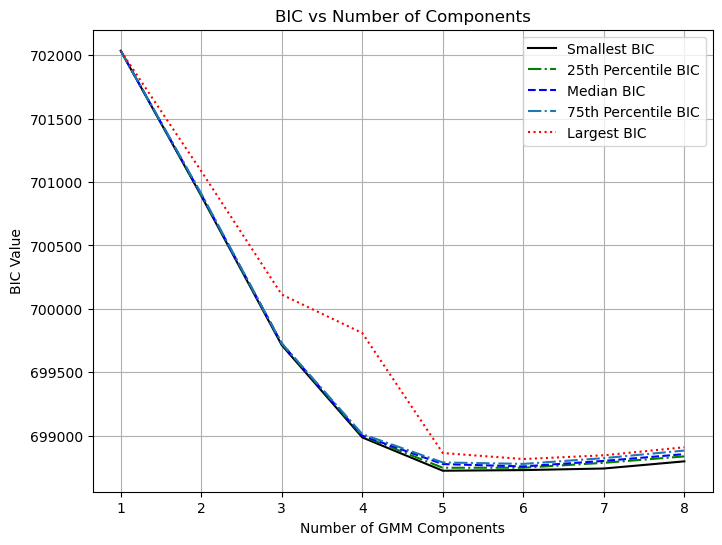

In [36]:
plot_bic_vs_n_components(bic_values_mp1)

# MP2

In [37]:
bic_values_mp2 = compute_bic_vs_n_components(df_mp2, max_components=8, n_init=50)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [6:36:55<00:00, 2977.00s/it]  


In [38]:
with open("bic_values_mp2.json", "w") as f:
    json.dump(bic_values_mp2, f)


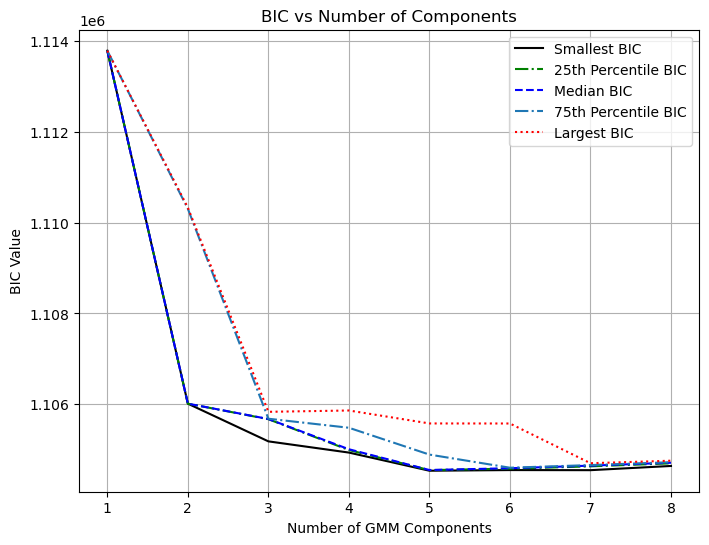

In [39]:
plot_bic_vs_n_components(bic_values_mp2)